# Ginkgo clustering environment

## Setup

In [35]:
%matplotlib inline

import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DWrapper


In [12]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [13]:
set_output(True)
env = gym.make("GinkgoLikelihood-v0")
state = env.reset()
env.render()

15:52 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
15:52 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 13 leaves
15:52 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
15:52 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 9 leaves
15:52 ginkgo_rl.envs.ginkg INFO    9 particles:
15:52 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  0.4,   0.2,   0.2,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.7,   0.3,   0.4,   0.4)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.0,   0.0,   0.0,   0.0)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.4,   0.2,   0.2,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  0.2,   0.1,   0.1,   0.1)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  1.6,   0.8,   1.1,   0.8)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  0.4,   0.3,   0.1,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  0.4,   0.3,   0.2,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 8] = (  0.0,   0.0,   0.0,   0.0)


In [14]:
# Merge two particles
action = 0, 1

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


15:52 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (0, 1)
15:52 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (0, 1): -9.068304061889648
15:52 ginkgo_rl.envs.ginkg DEBUG   Merging particles 0 and 1. New state has 8 particles.
15:52 ginkgo_rl.envs.ginkg INFO    8 particles:
15:52 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  1.1,   0.5,   0.7,   0.6)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.0,   0.0,   0.0,   0.0)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.4,   0.2,   0.2,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.2,   0.1,   0.1,   0.1)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  1.6,   0.8,   1.1,   0.8)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  0.4,   0.3,   0.1,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  0.4,   0.3,   0.2,   0.2)
15:52 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  0.0,   0.0,   0.0,   0.0)


Reward: -9.068304061889648
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 0, 'j': 1}


In [15]:
env.close()

## Env checker

In [16]:
set_output(False)
env = gym.make("GinkgoLikelihood-v0")
check_env(env)
env.close()

## Reward distribution for random actions

In [17]:
n_steps = 10000

set_output(False)
env = gym.make("GinkgoLikelihood-v0")
state = env.reset()
rewards, legal = [], []

for _ in range(n_steps):
    action = env.action_space.sample()
    legal.append(env.check_legality(action))
    _, reward, _, _ = env.step(action)
    rewards.append(reward)


------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------


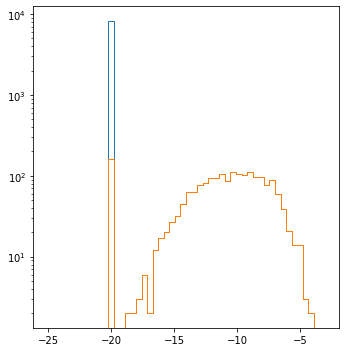

In [18]:
range_ = (-25.1, -3)

rewards = np.asarray(rewards)
legal = np.asarray(legal)

fig = plt.figure(figsize=(5,5))
plt.hist(rewards, range=range_, bins=50, histtype="step")
plt.hist(rewards[legal], range=range_, bins=50, histtype="step")
plt.tight_layout()
plt.yscale("log")
plt.show()


## Let's let some RL agents loose!

In [50]:
log_dirs = []
models = {}
wrap1ds = {}

def train(algorithm, algo_class, policy_class, wrap1d=False, n_steps=100000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make("GinkgoLikelihood1D-v0" if wrap1d else "GinkgoLikelihood-v0")
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    wrap1ds[algorithm] = wrap1d
    env.close()


def run(algorithm):
    model = models[algorithm]
    
    set_output(True)
    env = gym.make("GinkgoLikelihood1D-v0" if wrap1ds[algorithm] else "GinkgoLikelihood-v0")
    state = env.reset()
    done = False
    steps = 0

    while not done and steps < int(1.e5):
        action, _states = model.predict(state)
        obs, reward, done, info = env.step(action)
        env.render()
        steps += 1
    
    env.close()


## DQN

In [51]:
model = train("dqn", DQN, DQNMlpPolicy, wrap1d=True)

------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )
/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/likelihood_invM.py:46: RuntimeWarning: invalid value encountered in log
  return -np.log(1 - np.exp(- lam)) + np.log(1 - np.exp(-lam * t_cut / tP))


------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
--------

In [62]:
run("dqn")

17:21 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
17:21 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 12 leaves
17:21 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
17:21 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 14 leaves
17:21 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (1, 0)
17:21 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (1, 0): -8.601128578186035
17:21 ginkgo_rl.envs.ginkg DEBUG   Merging particles 1 and 0. New state has 13 particles.
17:21 ginkgo_rl.envs.ginkg INFO    13 particles:
17:21 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  0.5,   0.3,   0.3,   0.2)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.1,   0.1,   0.1,   0.1)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.1,   0.1,   0.1,   0.0)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.3,   0.2,   0.2,   0.1)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  0.0,   0.0,   0.0,   0.0)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  0.3,   0.2,   0.1,   0.1)
1

## PPO

In [53]:
model = train("ppo", PPO2, MlpPolicy)

------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------


In [61]:
run("ppo")

17:21 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
17:21 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 10 leaves
17:21 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
17:21 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 10 leaves
17:21 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: [1 0]
17:21 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action [1 0]: -5.808651924133301
17:21 ginkgo_rl.envs.ginkg DEBUG   Merging particles 1 and 0. New state has 9 particles.
17:21 ginkgo_rl.envs.ginkg INFO    9 particles:
17:21 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  0.9,   0.3,   0.7,   0.5)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.2,   0.1,   0.1,   0.1)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.1,   0.0,   0.1,   0.0)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.0,   0.0,   0.0,   0.0)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  0.0,   0.0,   0.0,   0.0)
17:21 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  0.9,   0.6,   0.5,   0.6)
17:21

## Results

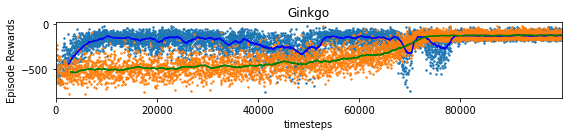

In [60]:
results_plotter.plot_results(log_dirs, 1e5, results_plotter.X_TIMESTEPS, "Ginkgo")
